# Predicting House Sale Prices 
In this project, I am going to create a multiple linear regression model which predicit house sale prices in the city of Ames, Iowa. 


The result is that average RMSE is $26344.835 with Kfold validation(k=5). 

In terms of R2 and adjusted R2, they are like below. They are calculated when I implement train/test validation 
- R squared is about 0.8819061471098402
- Adjusted R squared is about 0.8810503945526651

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Read Dataset

You can download a dataset I will work on from [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt)

In [2]:
housing = pd.read_csv("AmesHousing.txt",sep='\t')

In [3]:
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
#get familiar with the dataset 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Drop columns with many missing values

In this section, we are going to drop columns with many missing valeus. Specifically, columns, whose missing values occupy more than 25 % of their values, will be dropped.  At the same time, I will drop columns I think are unnecessary for our model.

In [5]:
#copy df
housing_copied = housing.copy()

In [6]:
#drop columns which I think are unnecessary. 
dataframe_dropped = housing_copied.drop(['Order','PID','Mo Sold','Sale Type','Sale Condition'],axis=1)

In [7]:
#dropping columns whose missing values are more than 25% of data
counts_missing = dataframe_dropped.isnull().sum()
proportion_missing = counts_missing / len(dataframe_dropped)
index_more_than25 = proportion_missing[proportion_missing>0.25].index
dataframe_no25  = dataframe_dropped.drop(index_more_than25,axis=1)

In [8]:
dataframe_no25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 72 columns):
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       2930 non-null object
Exterior 2nd      

## Feature Engineering(numerical columns) 

I am going to find good candidates for our model. For now, I will focus correlation between a dependant variable(```SalePrice```) and independent variables and correlation between independent variables. 
I will not work on missing values and outliers for now. I will deal with them later. 

In [9]:
# getting numerical data
numerical_data = dataframe_no25.select_dtypes(['float64','int64'])

In [10]:
numerical_data.head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,...,528.0,210,62,0,0,0,0,0,2010,215000
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,730.0,140,0,0,0,120,0,0,2010,105000
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,312.0,393,36,0,0,0,0,12500,2010,172000
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,...,522.0,0,0,0,0,0,0,0,2010,244000
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,482.0,212,34,0,0,0,0,0,2010,189900


In [11]:
# get rid of categorical columns encoded as numerical values. 
numerical_data = numerical_data.drop(['MS SubClass','Overall Qual','Overall Cond'],axis=1)

In [12]:
# add new feature expressing difference between Yr sold and Year Remod/Add 
numerical_data['years_until_sold'] = numerical_data['Yr Sold'] - numerical_data['Year Remod/Add']

In [13]:
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 34 columns):
Lot Frontage        2440 non-null float64
Lot Area            2930 non-null int64
Year Built          2930 non-null int64
Year Remod/Add      2930 non-null int64
Mas Vnr Area        2907 non-null float64
BsmtFin SF 1        2929 non-null float64
BsmtFin SF 2        2929 non-null float64
Bsmt Unf SF         2929 non-null float64
Total Bsmt SF       2929 non-null float64
1st Flr SF          2930 non-null int64
2nd Flr SF          2930 non-null int64
Low Qual Fin SF     2930 non-null int64
Gr Liv Area         2930 non-null int64
Bsmt Full Bath      2928 non-null float64
Bsmt Half Bath      2928 non-null float64
Full Bath           2930 non-null int64
Half Bath           2930 non-null int64
Bedroom AbvGr       2930 non-null int64
Kitchen AbvGr       2930 non-null int64
TotRms AbvGrd       2930 non-null int64
Fireplaces          2930 non-null int64
Garage Yr Blt       2771 non-null flo

### Correlation between independent variables and a dependent

In [14]:
corr_with_price = numerical_data.corr().loc['SalePrice']

In [15]:
corr_with_price

Lot Frontage        0.357318
Lot Area            0.266549
Year Built          0.558426
Year Remod/Add      0.532974
Mas Vnr Area        0.508285
BsmtFin SF 1        0.432914
BsmtFin SF 2        0.005891
Bsmt Unf SF         0.182855
Total Bsmt SF       0.632280
1st Flr SF          0.621676
2nd Flr SF          0.269373
Low Qual Fin SF    -0.037660
Gr Liv Area         0.706780
Bsmt Full Bath      0.276050
Bsmt Half Bath     -0.035835
Full Bath           0.545604
Half Bath           0.285056
Bedroom AbvGr       0.143913
Kitchen AbvGr      -0.119814
TotRms AbvGrd       0.495474
Fireplaces          0.474558
Garage Yr Blt       0.526965
Garage Cars         0.647877
Garage Area         0.640401
Wood Deck SF        0.327143
Open Porch SF       0.312951
Enclosed Porch     -0.128787
3Ssn Porch          0.032225
Screen Porch        0.112151
Pool Area           0.068403
Misc Val           -0.015691
Yr Sold            -0.030569
SalePrice           1.000000
years_until_sold   -0.534940
Name: SalePric

For now, I will follow a convention that correlation above 0.3 or below -0.3 indicate a strong linear relationship. 

In [16]:
boolean_corr = corr_with_price.abs() >= 0.3
highly_corr= corr_with_price[boolean_corr]
highly_corr

Lot Frontage        0.357318
Year Built          0.558426
Year Remod/Add      0.532974
Mas Vnr Area        0.508285
BsmtFin SF 1        0.432914
Total Bsmt SF       0.632280
1st Flr SF          0.621676
Gr Liv Area         0.706780
Full Bath           0.545604
TotRms AbvGrd       0.495474
Fireplaces          0.474558
Garage Yr Blt       0.526965
Garage Cars         0.647877
Garage Area         0.640401
Wood Deck SF        0.327143
Open Porch SF       0.312951
SalePrice           1.000000
years_until_sold   -0.534940
Name: SalePrice, dtype: float64

### correlation between independent variables

Strong correlation between independent variables will cause multicollinearity. It is not good practice to include columns correlated each other in linear regression model.  

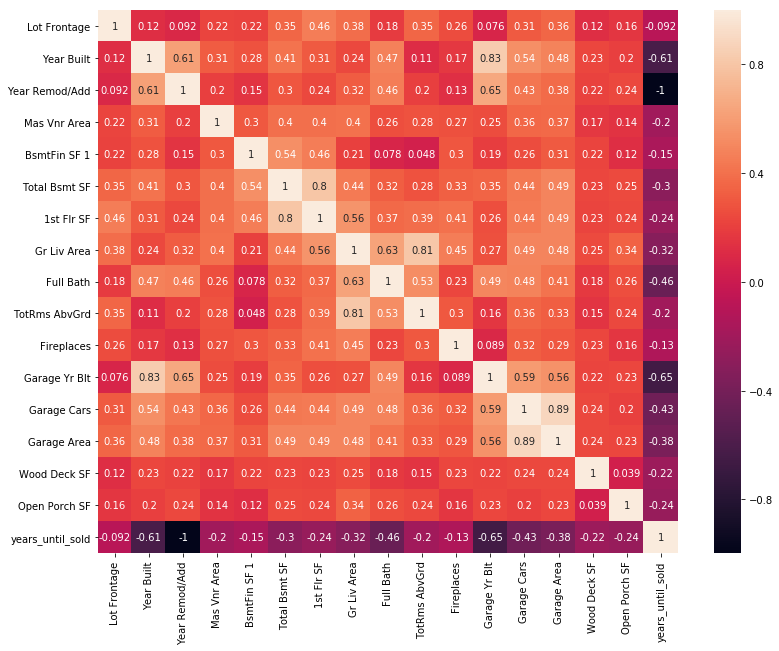

In [17]:
%matplotlib inline
plt.figure(figsize=(13,10))
sns.heatmap(numerical_data[highly_corr.index.drop('SalePrice')].corr(),annot=True)

I can see....
- ```Garage Yr Blt``` is highly correlated with ```Year Built```.
- one of ``` Year Remod/Add``` and ```years_until_sold``` should be dropped. 
- ```1st Flr SF``` and ```Total Bsmt SF``` are strongly correlated. 
- ``` Gr Liv Area``` is strongly correlated with ```TotRms AbvGrd```.
- ```Garage Cars``` is very strongly correlated with ```Garage Area```. 

Based on this, I will drop ```Garage Yr Blt```, ``` years_until_sold```,```1st Flr Sf```, ```TotRms AbvGrd```,and```Garage Area ```. This is because, they are less correlated with ```SalePrice```. 

In [18]:
numerical_candidates = highly_corr.drop(['Garage Yr Blt','years_until_sold','1st Flr SF','TotRms AbvGrd','Garage Area'])

In [19]:
numerical_candidates_index=numerical_candidates.drop('SalePrice').index

In [20]:
numerical_candidates_index

Index(['Lot Frontage', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Fireplaces', 'Garage Cars', 'Wood Deck SF', 'Open Porch SF'],
      dtype='object')

In [21]:
dataframe_no25[numerical_candidates_index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 12 columns):
Lot Frontage      2440 non-null float64
Year Built        2930 non-null int64
Year Remod/Add    2930 non-null int64
Mas Vnr Area      2907 non-null float64
BsmtFin SF 1      2929 non-null float64
Total Bsmt SF     2929 non-null float64
Gr Liv Area       2930 non-null int64
Full Bath         2930 non-null int64
Fireplaces        2930 non-null int64
Garage Cars       2929 non-null float64
Wood Deck SF      2930 non-null int64
Open Porch SF     2930 non-null int64
dtypes: float64(5), int64(7)
memory usage: 274.8 KB


For now, they are good candidates for our model. 

## Feature Engineering (categorical) 

In [22]:
categorical_data = dataframe_no25.select_dtypes('object')

In [23]:
# concatenating numerical categorical columns
category=pd.concat([categorical_data,dataframe_no25[['MS SubClass','Overall Qual','Overall Cond']]],axis=1)

In [24]:
category.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,MS SubClass,Overall Qual,Overall Cond
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,Typ,Attchd,Fin,TA,TA,P,20,6,5
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,TA,Typ,Attchd,Unf,TA,TA,Y,20,5,6
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Gd,Typ,Attchd,Unf,TA,TA,Y,20,6,6
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Ex,Typ,Attchd,Fin,TA,TA,Y,20,7,5
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,60,5,5


In [25]:
#making them into category dtype
df_category=category.apply(lambda x: x.astype('category'))

In [26]:
df_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 39 columns):
MS Zoning         2930 non-null category
Street            2930 non-null category
Lot Shape         2930 non-null category
Land Contour      2930 non-null category
Utilities         2930 non-null category
Lot Config        2930 non-null category
Land Slope        2930 non-null category
Neighborhood      2930 non-null category
Condition 1       2930 non-null category
Condition 2       2930 non-null category
Bldg Type         2930 non-null category
House Style       2930 non-null category
Roof Style        2930 non-null category
Roof Matl         2930 non-null category
Exterior 1st      2930 non-null category
Exterior 2nd      2930 non-null category
Mas Vnr Type      2907 non-null category
Exter Qual        2930 non-null category
Exter Cond        2930 non-null category
Foundation        2930 non-null category
Bsmt Qual         2850 non-null category
Bsmt Cond         2850 non-null 

In [27]:
df_category.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,MS SubClass,Overall Qual,Overall Cond
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,Typ,Attchd,Fin,TA,TA,P,20,6,5
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,TA,Typ,Attchd,Unf,TA,TA,Y,20,5,6
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Gd,Typ,Attchd,Unf,TA,TA,Y,20,6,6
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Ex,Typ,Attchd,Fin,TA,TA,Y,20,7,5
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,60,5,5


Now to select good categorical candidates for our model. I will use a technique introduced in this [post](https://machinelearningmastery.com/feature-selection-machine-learning-python/). The technique calculates ANOVA F-value for each feature. Then, I will pick top 3 features for potential candidates for our model. 

In [28]:
# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X = df_category.apply(lambda x:x.cat.codes)
Y = dataframe_no25['SalePrice']
# feature extraction
test = SelectKBest(score_func=f_classif, k=3)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[1.877 4.295 1.477 1.109 1.674 0.974 1.201 1.196 0.929 1.987 1.004 1.15
 1.301 1.241 1.022 1.035 1.435 4.709 0.973 1.743 2.455 1.53  1.443 1.054
 1.153 1.678 1.551 1.756 1.105 2.984 0.858 1.135 1.468 1.614 1.621 1.634
 0.957 7.407 1.249]
[[1 3 5]
 [1 3 4]
 [1 3 5]
 [1 2 6]
 [1 3 4]]


In [29]:
scores = pd.Series(fit.scores_,index=df_category.columns)
sorted_scores=scores.sort_values(ascending=False)

In [30]:
sorted_scores.head(10)

Overall Qual    7.407249
Exter Qual      4.708601
Street          4.294796
Kitchen Qual    2.984350
Bsmt Qual       2.454814
Condition 2     1.986634
MS Zoning       1.877087
Central Air     1.755954
Foundation      1.743334
Heating         1.677843
dtype: float32

Top 3 categorical variables seem to be good. Let's see relationships with SalePrice visually. 

In [31]:
top3 = sorted_scores[:3]
df_category[top3.index].head()

,Overall Qual,Exter Qual,Street
0,6,TA,Pave
1,5,TA,Pave
2,6,TA,Pave
3,7,Gd,Pave
4,5,TA,Pave


In [32]:
sample = dataframe_no25.sample(1460)

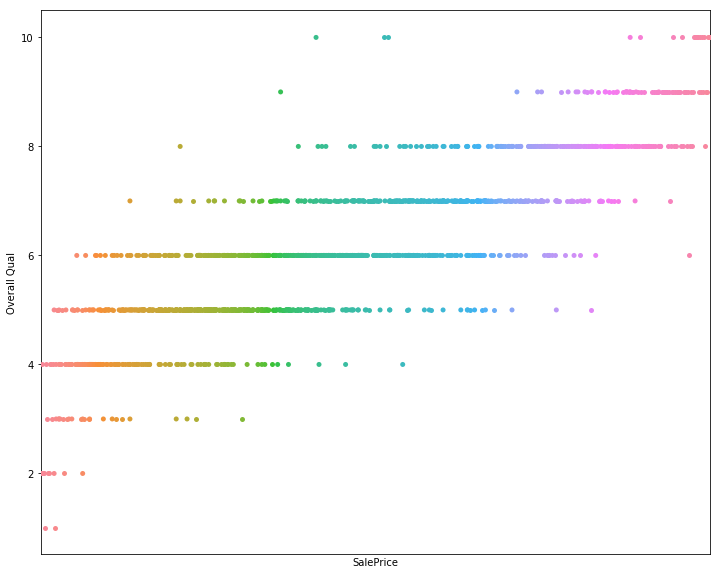

In [33]:
plt.figure(figsize=(12,10))
sns.swarmplot(x='SalePrice',y='Overall Qual',data=sample)
plt.tick_params(bottom=False,labelbottom=False)

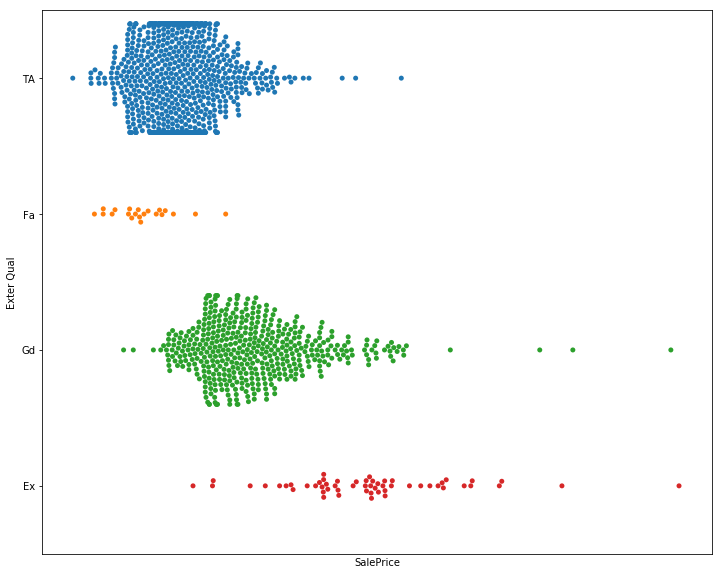

In [34]:
plt.figure(figsize=(12,10))
sns.swarmplot(x='SalePrice',y='Exter Qual',data=sample)
plt.tick_params(bottom=False,labelbottom=False)

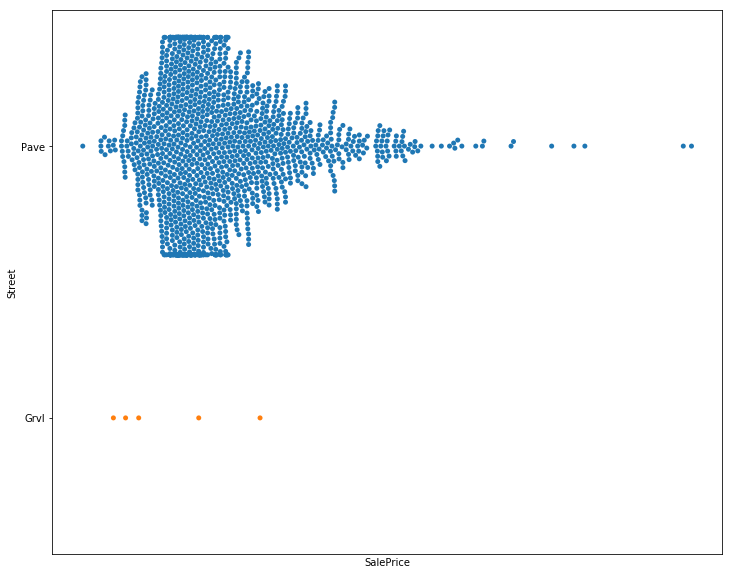

In [35]:
plt.figure(figsize=(12,10))
sns.swarmplot(x='SalePrice',y='Street',data=sample)
plt.tick_params(bottom=False,labelbottom=False)

I took a random sample since plotting these plots with all of data is really heavy task. Based on these plots, only ```Overall Qual``` column has a clear linear relationship with ```SalePrice```. Therefore, I will not use the other columns in modeling. I will use only ```Overall Qual``` column. 

## Missing Values

First, check how many we have such valeus

In [36]:
all_candidates=numerical_candidates_index.union(['Overall Qual','SalePrice'])

In [37]:
df_allcandidates = dataframe_no25[all_candidates]

In [38]:
df_allcandidates.head()

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Lot Frontage,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
0,639.0,2,1,2.0,1656,141.0,112.0,62,6,215000,1080.0,210,1960,1960
1,468.0,0,1,1.0,896,80.0,0.0,0,5,105000,882.0,140,1961,1961
2,923.0,0,1,1.0,1329,81.0,108.0,36,6,172000,1329.0,393,1958,1958
3,1065.0,2,2,2.0,2110,93.0,0.0,0,7,244000,2110.0,0,1968,1968
4,791.0,1,2,2.0,1629,74.0,0.0,34,5,189900,928.0,212,1997,1998


In [39]:
df_allcandidates.isnull().sum()/len(df_allcandidates)

BsmtFin SF 1      0.000341
Fireplaces        0.000000
Full Bath         0.000000
Garage Cars       0.000341
Gr Liv Area       0.000000
Lot Frontage      0.167235
Mas Vnr Area      0.007850
Open Porch SF     0.000000
Overall Qual      0.000000
SalePrice         0.000000
Total Bsmt SF     0.000341
Wood Deck SF      0.000000
Year Built        0.000000
Year Remod/Add    0.000000
dtype: float64

Relatively, ```Lot Frontage``` has many missing values. I think that it is okay to drop the column. Although the column has correlation of 0.35 with our target column, it is not really high. Moreover, it is not really meaningful information in deciding house prices. So, I will drop that. 

In [40]:
all_candidates_new=all_candidates.drop('Lot Frontage')

Let's investigate other columns with missing values. 

In [41]:
update_allcandidates = df_allcandidates[all_candidates_new]

In [42]:
update_allcandidates[update_allcandidates[['BsmtFin SF 1','Garage Cars','Mas Vnr Area','Total Bsmt SF']].isnull().any(axis=1)]

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
55,625.0,2,2,2.0,1960,NaN,48,6,216500,860.0,288,2002,2002
484,651.0,1,2,3.0,2004,NaN,48,8,257500,870.0,0,2002,2002
517,0.0,0,2,2.0,1436,NaN,121,7,225000,1436.0,0,2008,2009
538,833.0,0,2,2.0,1200,NaN,41,7,184900,1176.0,0,2003,2003
867,0.0,0,2,2.0,1725,NaN,48,7,198500,840.0,0,2002,2002
1095,0.0,1,2,2.0,1414,NaN,35,7,176000,707.0,100,2002,2002
1119,666.0,1,2,2.0,1460,NaN,20,8,247000,1460.0,0,2006,2007
1122,0.0,0,2,2.0,1428,NaN,120,7,182000,1428.0,0,2007,2008
1127,0.0,0,2,2.0,1665,NaN,0,7,205950,813.0,0,2007,2007
1184,0.0,1,2,2.0,1812,NaN,112,7,205000,952.0,144,2002,2002


I will drop rows containing missing values in ```BsmtFin SF 1```,```Garage Cars``` or ```Total Bsmt SF```. For ```Mas Vnr Area```, I will impute with some statistic.

C:\Users\kohda\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(array([0.604, 0.616, 0.628, 0.64 , 0.654, 0.673, 0.69 , 0.709, 0.727,
        0.743, 0.764, 0.786, 0.807, 0.822, 0.834, 0.849, 0.864, 0.874,
        0.889, 0.897, 0.903, 0.912, 0.92 , 0.926, 0.928, 0.932, 0.939,
        0.944, 0.949, 0.954, 0.957, 0.962, 0.966, 0.968, 0.969, 0.972,
        0.974, 0.976, 0.977, 0.978, 0.981, 0.983, 0.984, 0.985, 0.986,
        0.987, 0.988, 0.989, 0.99 , 0.991, 0.991, 0.991, 0.991, 0.992,
        0.992, 0.993, 0.993, 0.994, 0.994, 0.994, 0.995, 0.995, 0.995,
        0.995, 0.996, 0.996, 0.996, 0.996, 0.997, 0.997, 0.998, 0.998,
        0.998, 0.998, 0.998, 0.998, 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.999, 0.999, 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   ]),
 array([   0.,   16.,   32.,   48.,   64.,   80.,   96.,  112.,  128.,
         144.,  160.,  176.,  192.,  208.,  224.,  240.,  256.,  272.,
         288.,  304.,  320.,  336.,  352.,  368.,  384.,  40

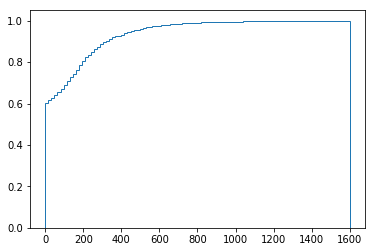

In [43]:
#let's see CDF of Mas Vnr Area
plt.hist(update_allcandidates['Mas Vnr Area'].dropna(),bins=100,normed=True,cumulative=True,histtype='step')

The distribution of ```Mas Vnr Area'``` is skewed. Let's use median to impute missing values in the column.

In [44]:
update_allcandidates['Mas Vnr Area'] = update_allcandidates['Mas Vnr Area'].fillna(update_allcandidates['Mas Vnr Area'].median())

C:\Users\kohda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
# find rows containing missing values
update_allcandidates[update_allcandidates[['BsmtFin SF 1','Garage Cars','Total Bsmt SF']].isnull().any(axis=1)]

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
1341,NaN,0,1,1.0,896,0.0,0,4,79000,NaN,0,1946,1950
2236,548.0,0,2,NaN,1828,0.0,0,5,150909,859.0,174,1923,1999


In [46]:
update_allcandidates.drop([1341,2236],inplace=True)

C:\Users\kohda\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [47]:
update_allcandidates.isnull().sum()

BsmtFin SF 1      0
Fireplaces        0
Full Bath         0
Garage Cars       0
Gr Liv Area       0
Mas Vnr Area      0
Open Porch SF     0
Overall Qual      0
SalePrice         0
Total Bsmt SF     0
Wood Deck SF      0
Year Built        0
Year Remod/Add    0
dtype: int64

Okay, it is clean now. I will look for outliers next. 

## Outliers

Having outliers will bring adverse effect on predition. If any, get rig of it. 

let's focus on ```SalePrice``` only for now.

In [48]:
#let's focus on SalePrice only 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scores = ss.fit_transform(update_allcandidates[['SalePrice']])

C:\Users\kohda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\kohda\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [49]:
sorted_scores = sorted(scores)

In [50]:
sorted_scores[:10]

[array([-2.104]),
 array([-2.1]),
 array([-1.827]),
 array([-1.826]),
 array([-1.822]),
 array([-1.79]),
 array([-1.772]),
 array([-1.763]),
 array([-1.713]),
 array([-1.701])]

In [51]:
sorted_scores[-10:]

[array([4.704]),
 array([5.034]),
 array([5.054]),
 array([5.142]),
 array([5.373]),
 array([5.394]),
 array([5.435]),
 array([5.561]),
 array([7.063]),
 array([7.188])]

scores with more than 7.0 are surprising.

In [52]:
update_allcandidates['SalePrice'].sort_values(ascending=False).head()

1767    755000
1760    745000
2445    625000
1063    615000
44      611657
Name: SalePrice, dtype: int64

I will drop the first two rows 

Okay, let's move on independent variables.

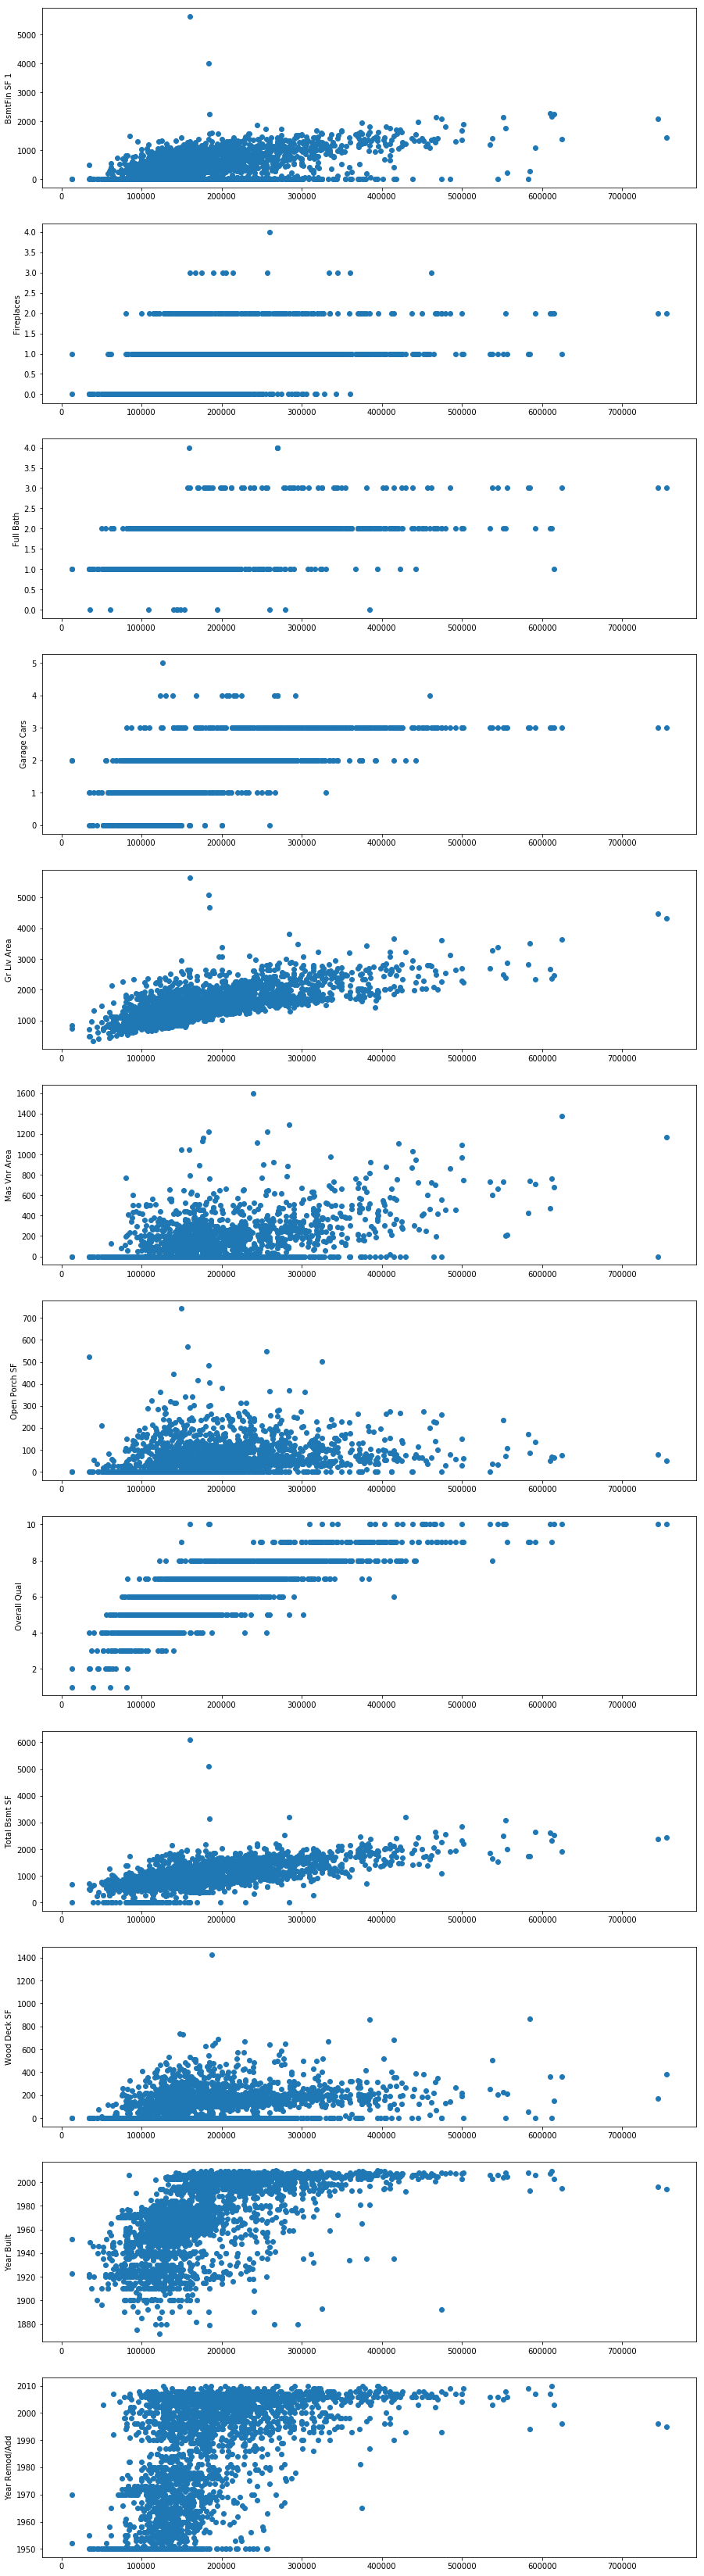

In [53]:
fig,axs = plt.subplots(nrows=12,ncols=1,figsize=(15,60))

ax_num=0
for col in update_allcandidates.columns.drop('SalePrice'):
    axs[ax_num].scatter(update_allcandidates['SalePrice'],update_allcandidates[col])
    axs[ax_num].set_ylabel(col)
    ax_num +=1

There are points which are off in ```BsmtFin SF 1```,```Gr Liv Area```,```Open Porch SF```,```Total Bsmt SF```,  and ```Wood Deck SF```.

Let's check those points for each column

In [54]:
update_allcandidates.sort_values(by='BsmtFin SF 1',ascending=False).head(2)

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
1498,5644.0,3,2,2.0,5642,796.0,292,10,160000,6110.0,214,2008,2008
2180,4010.0,2,2,3.0,5095,1224.0,484,10,183850,5095.0,546,2008,2009


In [55]:
update_allcandidates.sort_values(by='Gr Liv Area',ascending=False).head(3)

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
1498,5644.0,3,2,2.0,5642,796.0,292,10,160000,6110.0,214,2008,2008
2180,4010.0,2,2,3.0,5095,1224.0,484,10,183850,5095.0,546,2008,2009
2181,2260.0,1,3,3.0,4676,762.0,406,10,184750,3138.0,208,2007,2008


In [56]:
update_allcandidates.sort_values(by='Open Porch SF',ascending=False).head(4)

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
2195,371.0,0,2,0.0,2592,0.0,742,5,150000,1296.0,0,1923,1950
2065,267.0,1,3,2.0,2654,356.0,570,5,158000,671.0,128,1920,1996
1288,493.0,2,2,2.0,2792,0.0,547,6,256000,1510.0,0,1920,1950
726,495.0,0,1,0.0,720,0.0,523,4,34900,720.0,0,1920,1950


For this column, I will drop 2195 and 726

In [57]:
update_allcandidates.sort_values(by='Total Bsmt SF',ascending=False).head(2)

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
1498,5644.0,3,2,2.0,5642,796.0,292,10,160000,6110.0,214,2008,2008
2180,4010.0,2,2,3.0,5095,1224.0,484,10,183850,5095.0,546,2008,2009


In [58]:
update_allcandidates.sort_values(by='Wood Deck SF',ascending=False).head(1)

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
2293,1148.0,1,2,2.0,1356,0.0,0,6,188000,1244.0,1424,1977,1977


I will drop these rows from out data. 

In [59]:
#drop rows containing outliers in SalePrice and other columns
no_outliers_candidates = update_allcandidates.drop([2180,1498,2181,2293,1767,1760,2195,726])

In [60]:
no_outliers_candidates.head()

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,Overall Qual,SalePrice,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add
0,639.0,2,1,2.0,1656,112.0,62,6,215000,1080.0,210,1960,1960
1,468.0,0,1,1.0,896,0.0,0,5,105000,882.0,140,1961,1961
2,923.0,0,1,1.0,1329,108.0,36,6,172000,1329.0,393,1958,1958
3,1065.0,2,2,2.0,2110,0.0,0,7,244000,2110.0,0,1968,1968
4,791.0,1,2,2.0,1629,0.0,34,5,189900,928.0,212,1997,1998


## Requirements for Multivariate Techniques

In [this](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python), four assumptions for multivariate techniques are mentioned. 
They are...
- normality 
- Homoscedasticity
- Linearity
- Absence of correlated errors 

For this project, I do not go over those requirements. However, for normality section, I will see it for my practice purpose. What I am going to do and find in the practice will not be reflected on our model. Therefore, you can skip this section. 


Techniques I will use are adapted from this great Kaggle [post](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) 

## Normality of SalePrice

normal probability plot of Normal distribution is a straight line, so I will check it first. 

In [61]:
from scipy.stats import probplot

((array([-3.495, -3.25 , -3.115, ...,  3.115,  3.25 ,  3.495]),
  array([ 12789,  13100,  35000, ..., 611657, 615000, 625000], dtype=int64)),
 (73992.21936985134, 180514.05719178083, 0.9411281785935353))

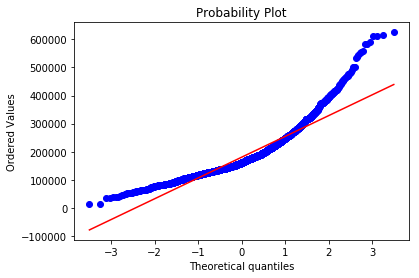

In [62]:
probplot(no_outliers_candidates['SalePrice'],plot=plt)

Not normally distributed well...let's take log of the values.

((array([-3.495, -3.25 , -3.115, ...,  3.115,  3.25 ,  3.495]),
  array([ 9.456,  9.48 , 10.463, ..., 13.324, 13.329, 13.346])),
 (0.4025640210563214, 12.020694048199482, 0.992866758757516))

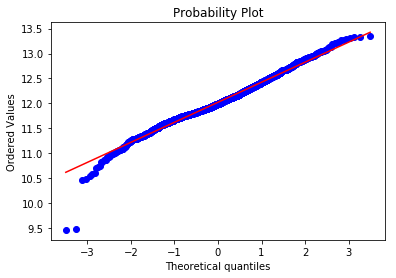

In [63]:
probplot(np.log(no_outliers_candidates['SalePrice']),plot=plt)

okay not bad 

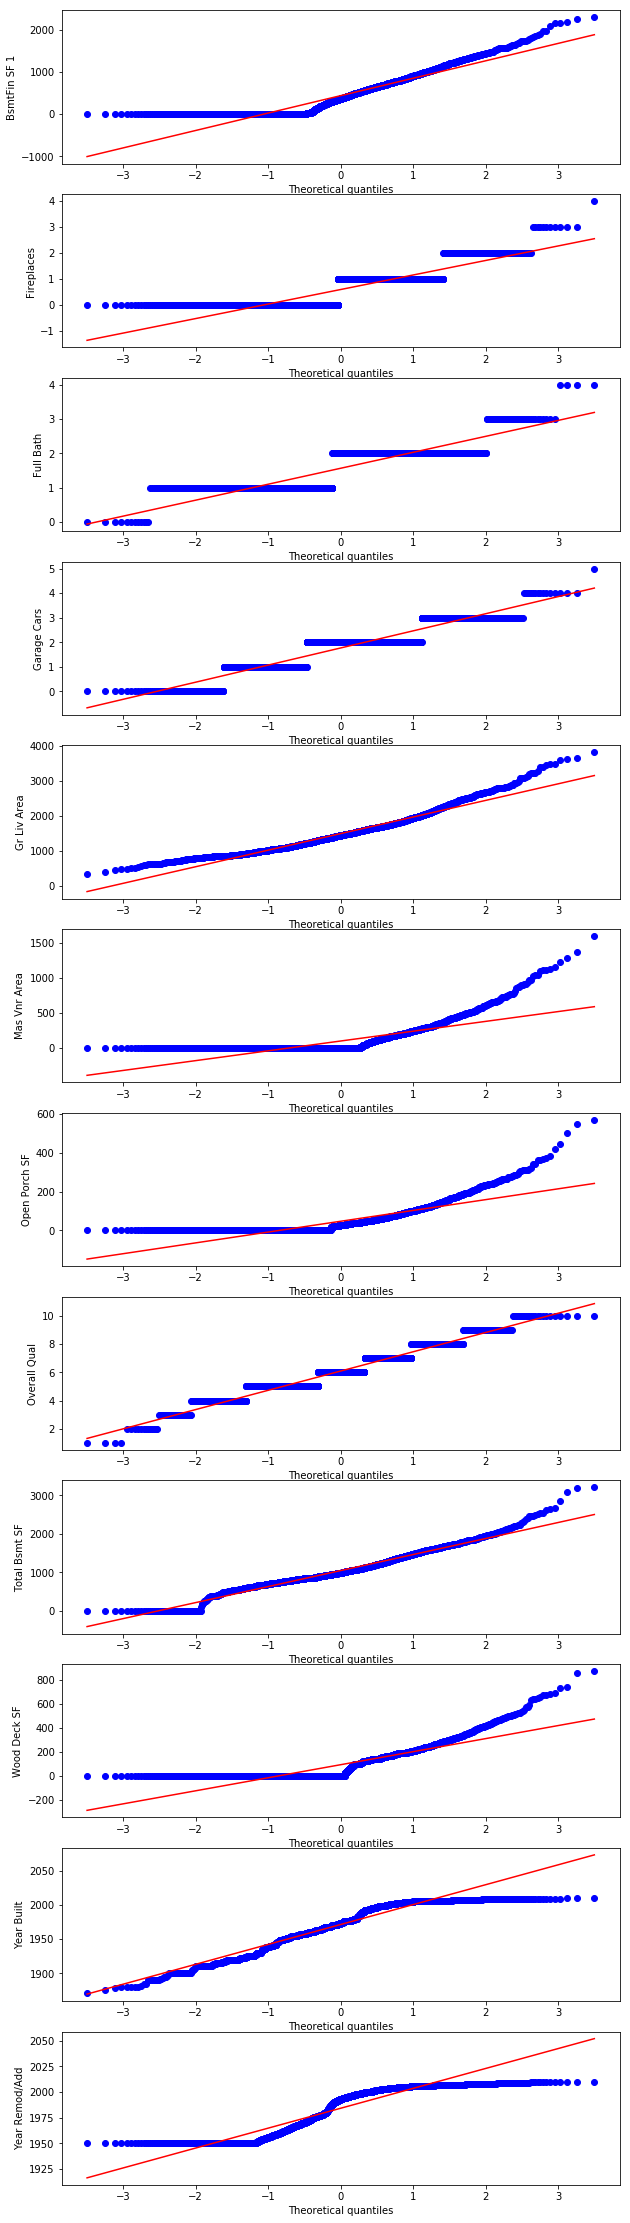

In [64]:
fig,axs = plt.subplots(nrows=12,ncols=1,figsize=(10,40))
ax_num = 0
for col in no_outliers_candidates.columns.drop('SalePrice'):
    probplot(no_outliers_candidates[col],plot=axs[ax_num])
    axs[ax_num].set_title('')
    axs[ax_num].set_ylabel(col)
    ax_num += 1

## Multiple Linear Regression Model. 

First, we will transform ```Overall Qual``` into dummy variables.

In [65]:
#create dummy variable
no_outliers_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 0 to 2929
Data columns (total 13 columns):
BsmtFin SF 1      2920 non-null float64
Fireplaces        2920 non-null int64
Full Bath         2920 non-null int64
Garage Cars       2920 non-null float64
Gr Liv Area       2920 non-null int64
Mas Vnr Area      2920 non-null float64
Open Porch SF     2920 non-null int64
Overall Qual      2920 non-null int64
SalePrice         2920 non-null int64
Total Bsmt SF     2920 non-null float64
Wood Deck SF      2920 non-null int64
Year Built        2920 non-null int64
Year Remod/Add    2920 non-null int64
dtypes: float64(4), int64(9)
memory usage: 319.4 KB


In [66]:
no_outliers_candidates['Overall Qual'] = no_outliers_candidates['Overall Qual'].astype('category')

In [67]:
dummy_overallQ = pd.get_dummies(no_outliers_candidates['Overall Qual'])
candidates_no_overallQ = no_outliers_candidates.drop('Overall Qual',axis=1)
final_candidates = pd.concat([candidates_no_overallQ,dummy_overallQ],axis=1)

In [68]:
final_candidates.head()

,BsmtFin SF 1,Fireplaces,Full Bath,Garage Cars,Gr Liv Area,Mas Vnr Area,Open Porch SF,SalePrice,Total Bsmt SF,Wood Deck SF,...,1,2,3,4,5,6,7,8,9,10
0,639.0,2,1,2.0,1656,112.0,62,215000,1080.0,210,...,0,0,0,0,0,1,0,0,0,0
1,468.0,0,1,1.0,896,0.0,0,105000,882.0,140,...,0,0,0,0,1,0,0,0,0,0
2,923.0,0,1,1.0,1329,108.0,36,172000,1329.0,393,...,0,0,0,0,0,1,0,0,0,0
3,1065.0,2,2,2.0,2110,0.0,0,244000,2110.0,0,...,0,0,0,0,0,0,1,0,0,0
4,791.0,1,2,2.0,1629,0.0,34,189900,928.0,212,...,0,0,0,0,1,0,0,0,0,0


## Multiple Linear Regression Model 

I crated a function to create a regression model with different validation techniques. The function takes three arguments. 
```df``` is for dataset. ```columns_drop``` are columns you want to drop from ```df``` if any(it is ```None``` by default). ```k``` determine a validation technique. Moreover, for k=0 and k=1, the outputs contain R squared and adjusted R2 squared values. 

In [69]:
from sklearn.metrics import r2_score

In [70]:
def train_and_test(df,columns_drop=None,k=0):
    if columns_drop != None:
        df = df.drop(columns_drop,axis=1)
    # k=0 is for train/test validation
    if k == 0:
        #use 50% of data for training
        data_amount = int(df.shape[0]*0.50)
        train = df.iloc[:data_amount]
        test = df.iloc[data_amount:]
        
        #make predictions
        lr = LinearRegression()
        columns = train.columns.drop('SalePrice')
        lr.fit(train[columns],train['SalePrice'])
        predictions = lr.predict(test[columns])
        
        #calculate r2 
        r2 = r2_score(test['SalePrice'],predictions)
        #adjusted r2
        adj_r2 = 1-((1-r2)*(len(df)-1)/(len(df)-len(columns)-1))
        
        rmse1 = mean_squared_error(test['SalePrice'],predictions)**(1/2)
        
        print("rmse:{rmse1}\nR2:{r2}\nAdjusted R2:{adj_r2}".format(rmse1=rmse1,r2=r2,adj_r2=adj_r2))

    #k=1 is for Holdout validation 
    elif k==1:
        #use 50% of data for training 
        data_amount = int(df.shape[0]*0.5)
        
        train = df.iloc[:data_amount]
        test = df.iloc[data_amount:]
        lr = LinearRegression()
        columns = train.columns.drop('SalePrice')
        lr.fit(train[columns],train['SalePrice'])
        predictions = lr.predict(test[columns])
        rmse1 = mean_squared_error(test['SalePrice'],predictions)**(1/2)
        r2_1= r2_score(test['SalePrice'],predictions)
        adj_r2_1 = 1-((1-r2_1)*(len(df)-1)/(len(df)-len(columns)-1))
        
        
        train = df.iloc[data_amount:]
        test = df.iloc[:data_amount]
        lr = LinearRegression()
        columns = train.columns.drop('SalePrice')
        lr.fit(train[columns],train['SalePrice'])
        predictions = lr.predict(test[columns])
        rmse2 = mean_squared_error(test['SalePrice'],predictions)**(1/2)
        r2_2 = r2_score(test['SalePrice'],predictions)
        adj_r2_2 = 1-((1-r2_2)*(len(df)-1)/(len(df)-len(columns)-1))
        
        avg_rmse = (rmse1+rmse2)/2
        avg_r2 = (r2_1+r2_2)/2
        avg_adj_r2 = (adj_r2_1+adj_r2_2)/2
        
        print("average rmse:{rmse1}\nR2:{r2}\nAdjusted R2:{adj_r2}".format(rmse1=avg_rmse,r2=avg_r2,adj_r2=avg_adj_r2))
    
    #k=2 is for KFold validation
    elif k ==2:
        kf = KFold(n_splits=5,shuffle=True,random_state=1)
        lr = LinearRegression()
        columns = df.columns.drop('SalePrice')
        mse = cross_val_score(lr,df[columns],df['SalePrice'],scoring='neg_mean_squared_error',
                       cv=kf)
           
        print('average rmse:{rmse1}'.format(rmse1=np.mean(np.abs(mse)**(1/2))))

In [72]:
train_and_test(final_candidates,k=2)

average rmse:26344.835155815206


# Conclusion 

When implementing KFold validation, the average rmse is 26344.835 in U.S. dollar. I think that it is still a big error in terms of context we have. I am not confatable with a predicition of house prices which is off by $26344.835. However, as a fisrt Machine Learning project, I think this is a good start. 